# COVID-19 forecasting using SEIR models

Mathematical modelling is an important component of epidemiology and infection disease research. In particular, compartmental models have been used since the early 20th century. Here, a population is divided into compartments and it is assumed that individuals in the same compartment have the same characteristics.

The SIR model is a well-known and relatively simplistic compartmental model consisting of three compartments: susceptible (S), infectious (I), and recovered/deceased/immune (R; sometimes referred to as “removed” in this notebook). The SIR model has many derivations that build upon it. Our focus, the SEIR model, includes an additional compartment for people who are exposed (E) and is often used for infections with a significant incubation period where individuals have been infected but are not yet infectious to others.

The variables (S, E, I, and R) represent how many (or the proportion of) people are in each compartment at a particular time. Since the SEIR model is dynamic, the numbers in each compartment may fluctuate over time and there are relationships between each of the states. For example, the number of susceptible (S) individuals falls as more individuals are exposed/infected, and the disease likely cannot break out again until a large portion of the population return to being susceptible (S). The SEIR model includes parameters which determine the rate at which individuals move from being susceptible to exposed (beta), from exposed to infected (epsilon), and from infected to recovered (gamma). Finally, SEIR models may include parameters for background mortality and birth rates, but often make the assumption that they are equal. It is important to note that any given SEIR model is based on a particular population and it may not be appropriate to use on other populations.

In this notebook, we construct an SEIR model for COVID-19 in Cook County, Illinois, using data sourced from Johns Hopkins University, but available within the Chicagoland COVID-19 Commons. We then perform an optimization of initial model parameter values and do some simple validation. This notebook is intended to demonstrate real-life usage of data for epidemiological modeling and is not intended for rigorous scientific interpretation.

## Setup notebook

If you need to install these libraries, uncomment and run this cell:

In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scipy
#!pip install gen3

Import the necessary modules:

In [2]:
%matplotlib inline
from datetime import datetime
import gen3
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import json
import requests
from matplotlib.dates import date2num, num2date
from scipy import integrate, optimize
import warnings

warnings.filterwarnings("ignore")

## Implement SEIR model

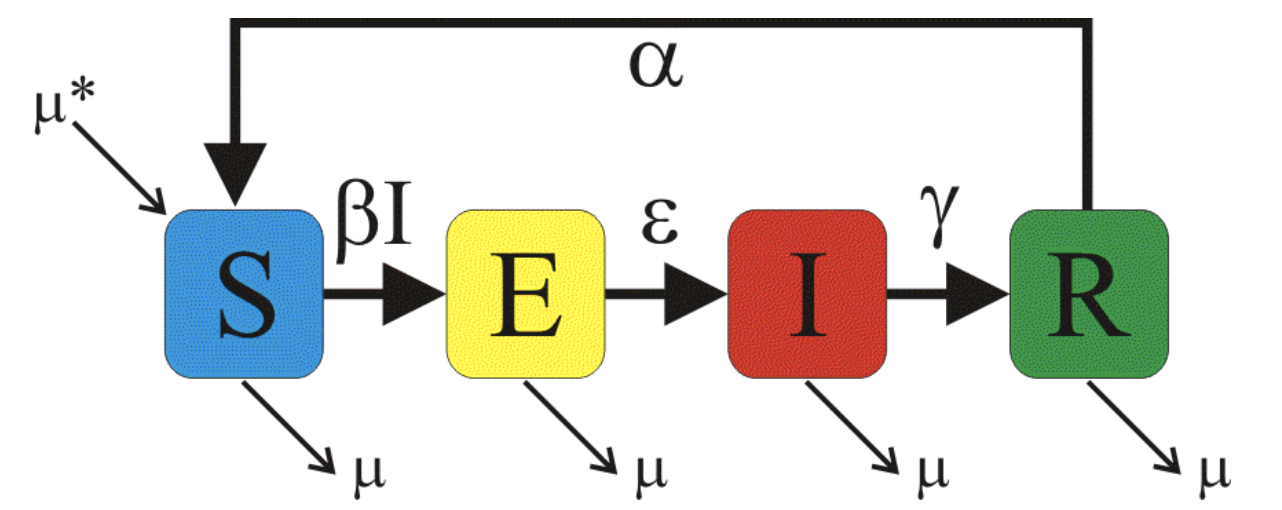

In [3]:
from IPython.display import Image
Image(filename='seir_diagram.png', width=400, height=400)

    dS/dt = -βSI;   dE/dt = βSI - ϵE;   dI/dt = ϵE - γI;   dR/dt = γI;
    
    R0 = β/γ;
    
    β : average contact rate in the population;
    ϵ : the inverse of the mean incubation period;   
    γ : the inverse of the mean infectious period;

The rate of change for each compartment in the SEIR model is given by a differential equation, as defined above. To implement the model we use these equations to compute the incremental change in value for each compartment per time step (per day, in this case). That is, starting at day 0, we go day by day and compute the increase or decrease in each compartment for the next day. What we end up with is a time-series of the relative frequency for each compartment for the duration of the outbreak.

In [4]:
def base_seir_model(init_vals, params, t):
    """SEIR model implementation.
    
    Takes lists of start values, parameters, and times and runs
    through the SEIR functions.
    
    Args:
        init_vals: Population distribution at start point
        params: change rate between status. beta: S --> E, epsilon: E --> I, gamma: I --> R
        t: progression time
    
    Returns:
        Population distribution at the end of the progression.
    """
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    epsilon, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
        next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
        next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
        next_R = R[-1] + (gamma * I[-1]) * dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

To run a simulation using the model we assign values to each of the model parameters, specify a set of initial conditions, and run the function. Parameters for the SEIR model define the rates of transition between compartments. The initial conditions which must be specified are the fixed population size, number of time steps to simulate, and relative frequency of each compartment at time step 0.

### Set up initial state and parameters, run simulation

For an initial run of the model we use parameter values as estimated in [Hellewell et al. 2020](https://www.medrxiv.org/content/10.1101/2020.02.08.20021162v1) (Incubation  = 5 days, ϵ = 0.2, R0 = 3.5) and initial conditions as follows: population size 5,180,493 (Cook County population 2020), time window 200 days, and initial counts of 10 exposed, 1 infectious, and the remainder of the population are susceptible, implying 0 removed. To derive β, we used γ = 0.5, therefore β = R0 * γ = 1.75

In [5]:
# Set up initial state
N = 5180493
S_0 = (N - 11) / N
E_0 = 10 / N
I_0 = 1 / N
R_0 = 0
init_vals = [S_0, E_0, I_0, R_0]

# Parameter reported by researchers
epsilon, beta, gamma = [0.2, 1.75, 0.5]
params = epsilon, beta, gamma

# define time interval
t_max = 150
dt = 1
t = np.linspace(0, t_max, int(t_max / dt) + 1)

# Run simulation
results = base_seir_model(init_vals, params, t)

#### Visualize COVID-19 progression

The function defined below is used to plot the results from the SEIR model.

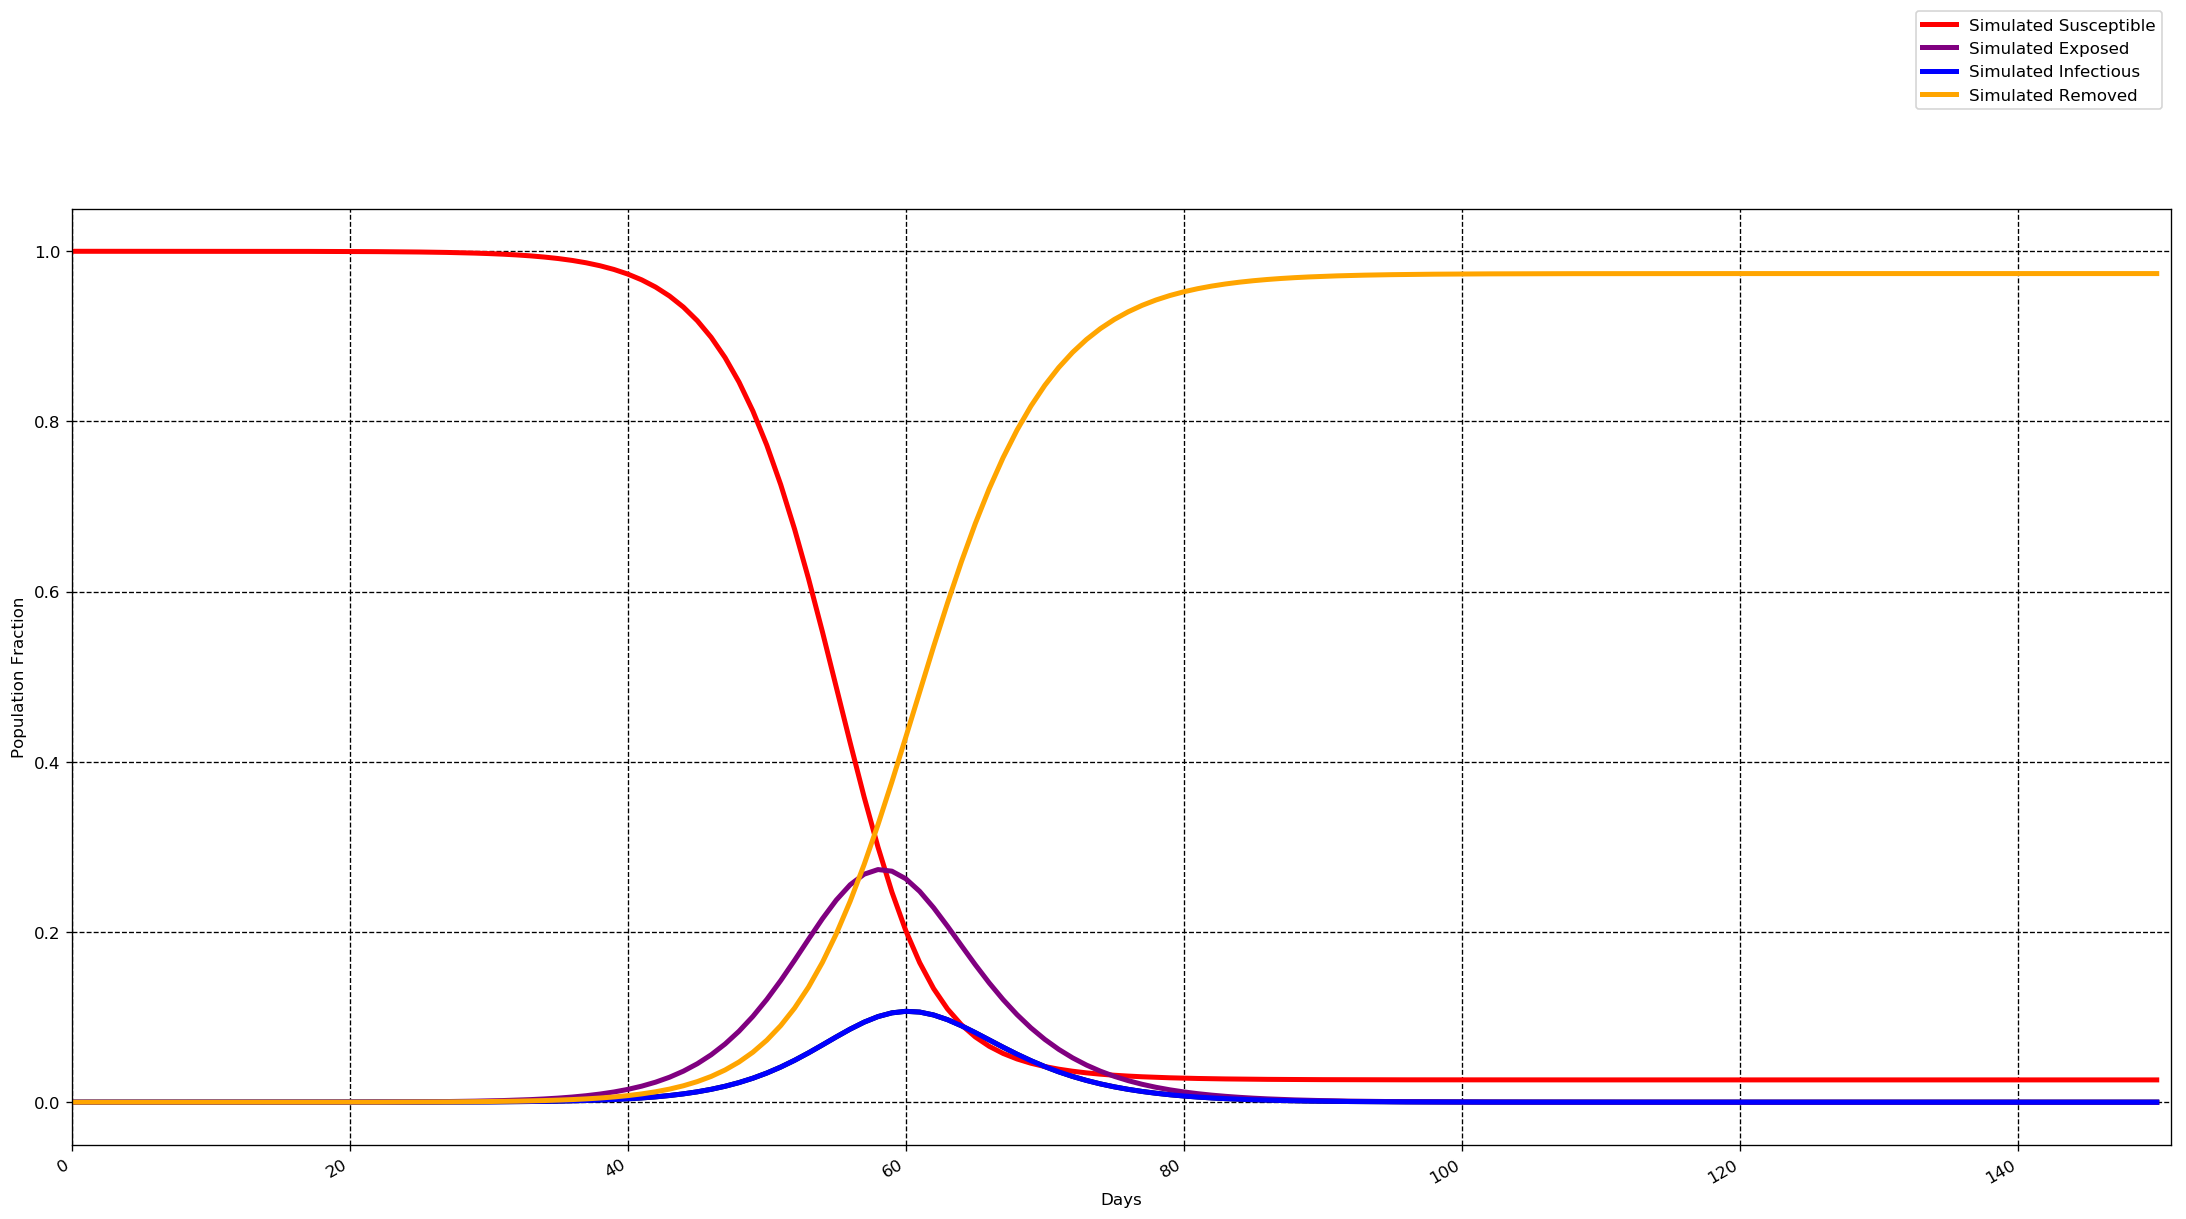

In [6]:
def plot_modeled(
    simulated_susceptible, simulated_exposure, simulated_infectious, simulated_remove
):
    """Helper function for plotting the results from the SEIR model.
    
    Args:
        simulated_susceptible: Predicted values for S
        simulated_exposure: Predicted values for E
        simulated_infectious: Predicted values for I
        simulated_remove: Predicted values for R
    """
    global times, numTimes
    startInd = 0
    numTimes = len(simulated_infectious)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind = np.arange(numTimes)
    indObs = np.arange(len(simulated_infectious))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color="black", linestyle="dashed")
    ax.xaxis.grid(True, color="black", linestyle="dashed")
    ax.set_axisbelow(True)
    fig.autofmt_xdate()

    (infectedp,) = ax.plot(indObs, simulated_infectious, linewidth=3, color="black")
    (sp,) = ax.plot(ind, simulated_susceptible, linewidth=3, color="red")
    (ep,) = ax.plot(ind, simulated_exposure, linewidth=3, color="purple")
    (ip,) = ax.plot(ind, simulated_infectious, linewidth=3, color="blue")
    (rp,) = ax.plot(ind, simulated_remove, linewidth=3, color="orange")
    ax.set_xlim(0, numTimes)
    ax.set_xlabel("Days")
    ax.set_ylabel("Population Fraction")

    plt.legend(
        [sp, ep, ip, rp],
        [
            "Simulated Susceptible",
            "Simulated Exposed",
            "Simulated Infectious",
            "Simulated Removed",
        ],
        loc="upper right",
        bbox_to_anchor=(1, 1.22),
        fancybox=True,
    )
    
plot_modeled(results[:, 0], results[:, 1], results[:, 2], results[:, 3])

Here we’ve plotted the relative frequency of each compartment over time. Starting at day 1 we can see that essentially the entire population is susceptible and a very small portion are exposed, infectious, or removed. Tracing the curves to the right we see a sharp drop in the susceptible curve with corresponding peaks in the exposed and infectious curves and sharp rise in the removed curve. As we move beyond the peak of the infectious curve we find that the compartments quickly stabilize to their long-run values. The outbreak comes to a close as the exposed and infectious curves approach zero. We observe that by the end of the outbreak the vast majority of the population will have become infected and subsequently passed through to the removed compartment (the removed curve stabilizes close to 1). In turn, in this simulation only a small portion of the population avoided infection (the susceptible curve stabilizes close to 0).

## Comparing Simulation Results Against Real Data

Due to lack of widespread testing it’s understood that there are many cases which do not get detected and therefore are not reflected in the reported case counts data. In particular, mild and asymptomatic cases are not being detected. While it is currently unknown what percentage of infections end up as mild or asymptomatic, that figure has been estimated (see papers referenced in [this article](https://www.nature.com/articles/d41586-020-00822-x)) to be as high as 40-50%. This means that any dataset can only at best offer a highly incomplete picture of the whole situation. In spite of this fact, validating simulation results from the model against real data is the only way to determine whether or not the model faithfully represents the actual outbreak. 

Although we cannot truly validate the model using an incomplete dataset, it is still valuable to compare simulation results against real data. Using confirmed case counts data for Cook County from the JHU COVID-19 dataset, we compare the simulated infection rate against the observed infection rate. It is important to note that true parameter values for the model vary by population - that is, parameter values used to model the Wuhan outbreak need not be the same as the parameter values used to model the New York City outbreak. Note that in this initial simulation we used parameter values which were not estimated from the Cook County population - accordingly, we expect to see deviations between the observed data and simulation results.

### Setup data

In [7]:
# Cook County population in 2020 is 5,180,493
# Query JHU covid-19 summary from covid19 gen3 data common

url = 'https://chicagoland.pandemicresponsecommons.org/'

def get_token():
    """
    Helper function for generating token.

    """
    with open("/home/jovyan/pd/credentials.json", "r") as f:
        creds = json.load(f)
    token_url = url + "user/credentials/api/access_token"
    token = requests.post(token_url, json=creds).json()["access_token"]
    return token

headers = {"Authorization": "bearer " + get_token()}

def download():
    """
    Helper function for downloading data from guppy.

    """
    api_url = url + "guppy/download"
    query = {
        "type": "location",
        "fields": [
            "province_state",
            "date",
            "confirmed",
            "deaths",
            "recovered"
        ],
        "filter":{
            "=":{
                "FIPS":"17031"
            }
        }
    }
    response = requests.post(
        api_url,
        json=query,
        headers=headers,
    )
    try:
        data = json.loads(response.text)
        return data[0]
    except:
        print("Error querying Guppy")
        return response.text

data =  download()
df = pd.DataFrame({'date':data['date'],'confirmed':data['confirmed'],'deaths':data['deaths']})
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df = df[df.date >= "2020-03-01"]

### Define comparison functions

In [8]:
def format_date(x, pos=None):
    """Helper funtion to format dates.
    
    Args:
        x: number of days since 0001-01-01 00:00:00 UTC, plus one.
    
    Kwargs:
        pos: time zone
    
    Returns:
        Dates are returned
    """
    thisind = np.clip(int(startInd + x + 0.5), startInd, startInd + numTimes - 1)
    return num2date(times[thisind]).strftime("%m/%d/%Y")


def validate_modeled(simulated_cases, cases):
    """Generates a plot of observed and predicted infected
    cases from the SEIR model.
        
    Args:
        simulated_infection: Predicted counts of infected cases.
        infection: Observed infection case counts.
    """
    global times, numTimes
    startInd = 0
    times = [date2num(s) for (s) in df.date]
    numTimes = len(simulated_cases)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind = np.arange(numTimes)
    indObs = np.arange(len(simulated_cases))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color="black", linestyle="dashed")
    ax.xaxis.grid(True, color="black", linestyle="dashed")
    ax.set_axisbelow(True)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    fig.autofmt_xdate()

    (infectedp,) = ax.plot(indObs, simulated_cases, linewidth=3, color="black")
    (si,) = ax.plot(ind, simulated_cases, linewidth=3, color="orange")
    (i,) = ax.plot(ind, cases, linewidth=3, color="blue")
    ax.set_xlim(0, numTimes)
    ax.set_xlabel("Date")
    ax.set_ylabel("Population Fraction")

    plt.legend(
        [si, i],
        ["Simulated Cases", "Observed Cases"],
        loc="upper right",
        bbox_to_anchor=(1, 1.22),
        fancybox=True,
    )

### Visualize comparison 

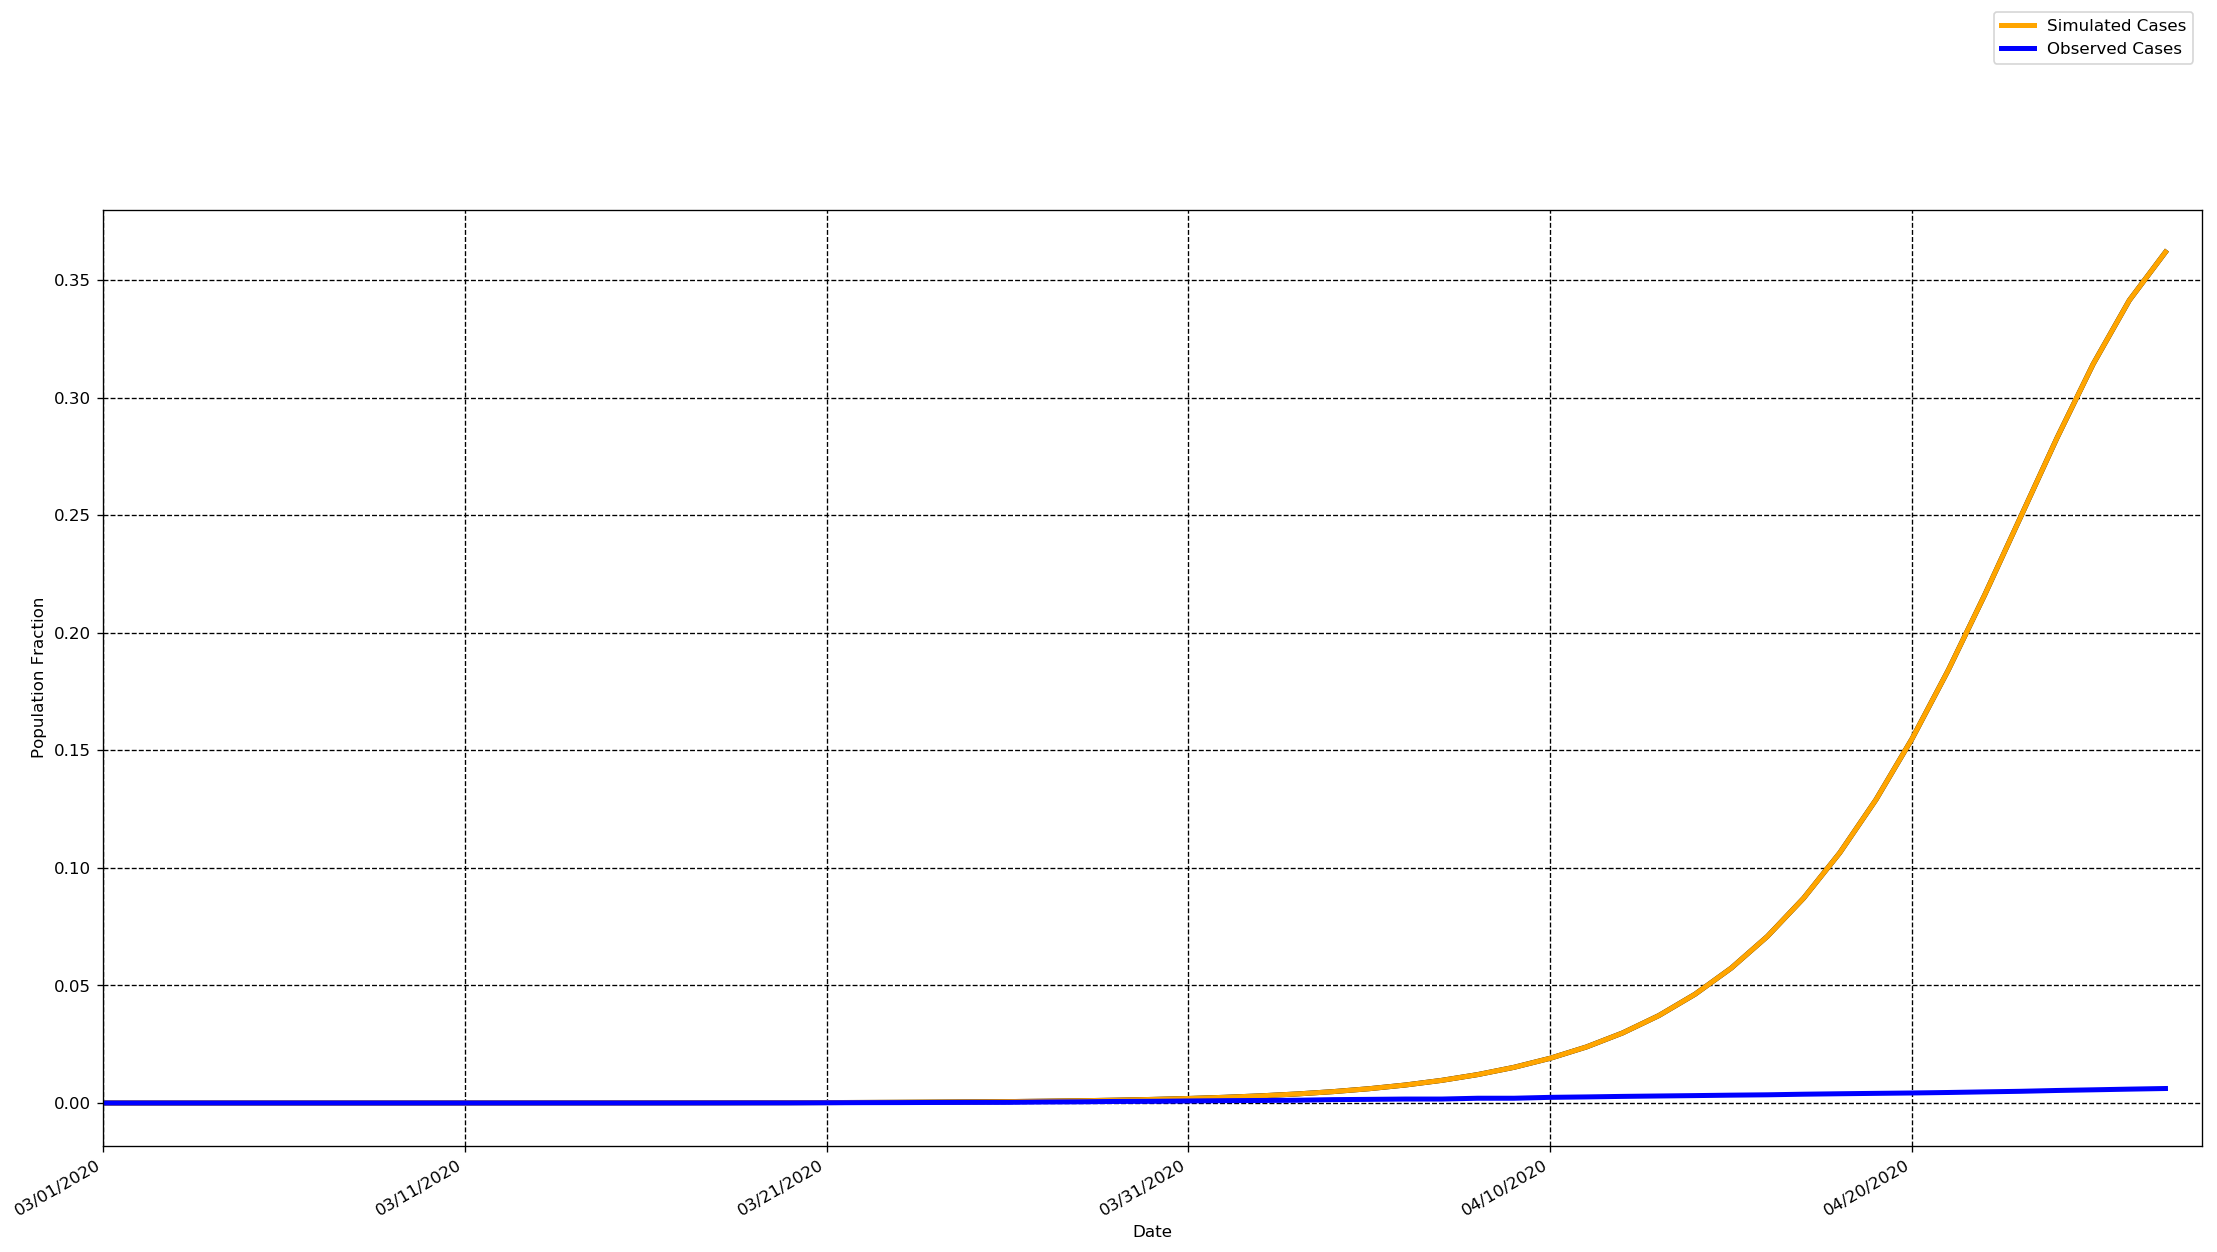

In [9]:
days = len(df.confirmed)
startInd = 0
cases = results[:days, 1] + results[:days, 2]
validate_modeled((results[:days, 1] + results[:days, 2]) , df.confirmed / N)

As expected, the simulated case counts do not align well with the reported case counts for Cook County. To improve the accuracy of our forecast, we will estimate parameter values for the model using reported case, death and recovered counts from the Cook County dataset. With the understanding that we are working with an incomplete and rapidly evolving dataset, and therefore that parameter values for the model are difficult to accurately estimate, we still expect to see deviations between the observed data and simulation results.

## Parameter Optimization

The optimization algorithm evaluates the simulated data using published parameter as the start point, calculates the difference between simulated data and observed data from Cook County, and updates the parameters to minimize the difference using the `L-BFGS-B` method iteratively. We set the maximum iteration as `1e7` and the convergence as `1e-8`.

In [10]:
class OptimizeParameters(object):
    """Handles the optimization of parameters for the SEIR model"""
    def __init__(self, init_vals, confirmed):
        """Initialize the parameter optimization class.
        
        Args:
            init_vals: Population distribution at start point.
            confirmed: Reported confirmed cases in Cook County.
        """
        self.init_vals = init_vals
        self.confirmed = confirmed

    def evaluate(self, params):
        """Method to evaluate the model given a set of parameters.
        
        Args:
            params: Epsilon, beta, gamma values..
        
        Returns:
            Lists of predicted values for E and I.
        """
        S_0, E_0, I_0, R_0 = self.init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        epsilon, beta, gamma = params
        dt = 1
        for _ in range(len(self.confirmed) - 1):
            next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
            next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
            next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
            next_R = R[-1] + (gamma * I[-1]) * dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        return E, I

    def error(self, params):
        """Estimates error.
        
        Args:
            params: Epsilon, beta, gamma values.
        
        Returns:
            Sum of squared residuals between simulated and observed cases, deaths plus recovered.
        """
        yEim, yIim = self.evaluate(params)
        yCim = [sum(i) for i in zip(yEim, yIim)]  
        res = sum(
              np.subtract(yCim, self.confirmed) ** 2
        )
        return res


    def optimize(self, params):
        """Perform optimization via minimization.

        Args:
            params: Epsilon, beta, gamma values.

        Returns:
            Optimized values of parameters.
        """
        res = optimize.minimize(
            self.error,
            params,
            method = "L-BFGS-B",
            bounds = [(0.01, 20.0), (0.01, 20.0), (0.01, 20.0)],
            options = {"xtol": 1e-8, "disp": True, "ftol": 1e-7, "maxiter": 1e8},
        )
        return res

### Run optimization

Confirmed COVID-19 cases underrepresents the COVID-19 infected population due to the lack of testing capacity. Anbibody test preliminary result from LA suggested that infected cases is between 221000 and 442000 with margin error while the confirmed cases is 13816. We postulated the testing capacity in Illinois is comparable to LA. Therefore, we calculated the infected cases by multiply confirmed cases with the ratio of 221000/13816 or 442000/13816. 

In [11]:
# Set up population distribution in initial state
min_ratio = 221000/13816
max_ratio = 442000/13816
infected_cases = df.confirmed / N

# Instantiate the class
min_seir_eval = OptimizeParameters(init_vals, infected_cases * min_ratio)
max_seir_eval = OptimizeParameters(init_vals, infected_cases * max_ratio)

# Run optimiza function
min_opt_p = min_seir_eval.optimize(params)
max_opt_p = max_seir_eval.optimize(params)

### Compare optimized SEIR model against real data

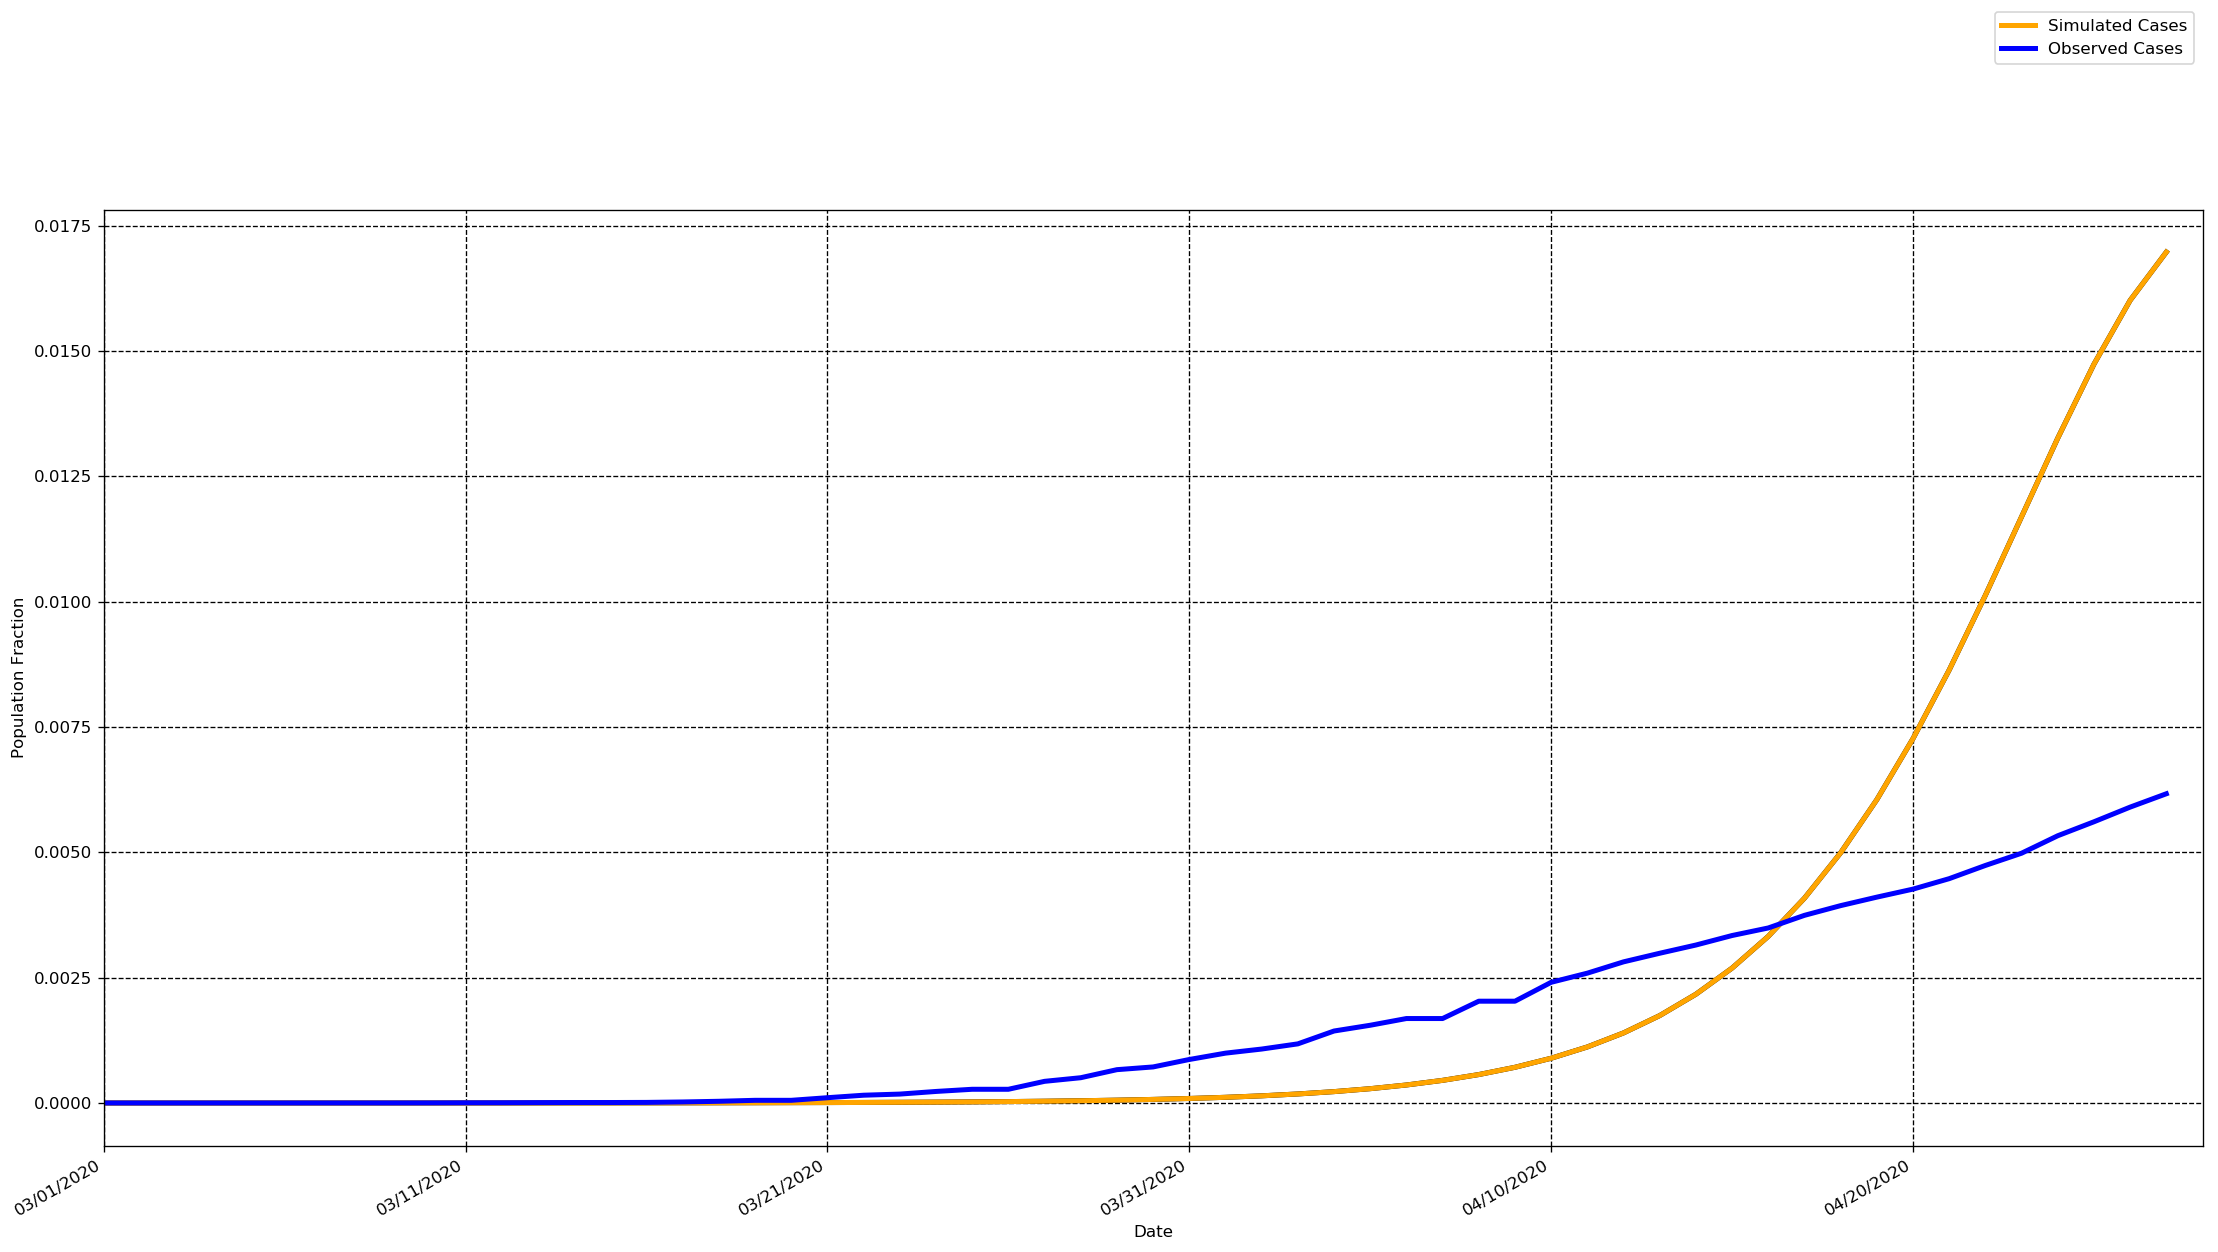

In [12]:
# define time interval
t_max = len(df.confirmed) + 40
dt = 1
t = np.linspace(0, t_max, int(t_max / dt) + 1)

min_results = base_seir_model(init_vals, min_opt_p.x, t)
max_results = base_seir_model(init_vals, max_opt_p.x, t)

min_simulated_cases = (min_results[:days,1] + min_results[:days,2]) * N/min_ratio
min_simulated_cases = [int(x) for x in min_simulated_cases]

max_simulated_cases = (max_results[:days,1] + max_results[:days,2]) * N/max_ratio
max_simulated_cases = [int(x) for x in max_simulated_cases]

avg_simulated_cases = [sum(i)/(2*N) for i in zip(min_simulated_cases, max_simulated_cases)]

validate_modeled(avg_simulated_cases, df.confirmed / N)

Using the optimized parameters, the simulated infected case counts (exposed + infectious) were generated. We then compare the simulated infection rate against the observed infection rate. There is a clear improvement in how well the predicted infected case proportions reflect the true infected case proportions.

### Plot SEIR compartment with simulated data

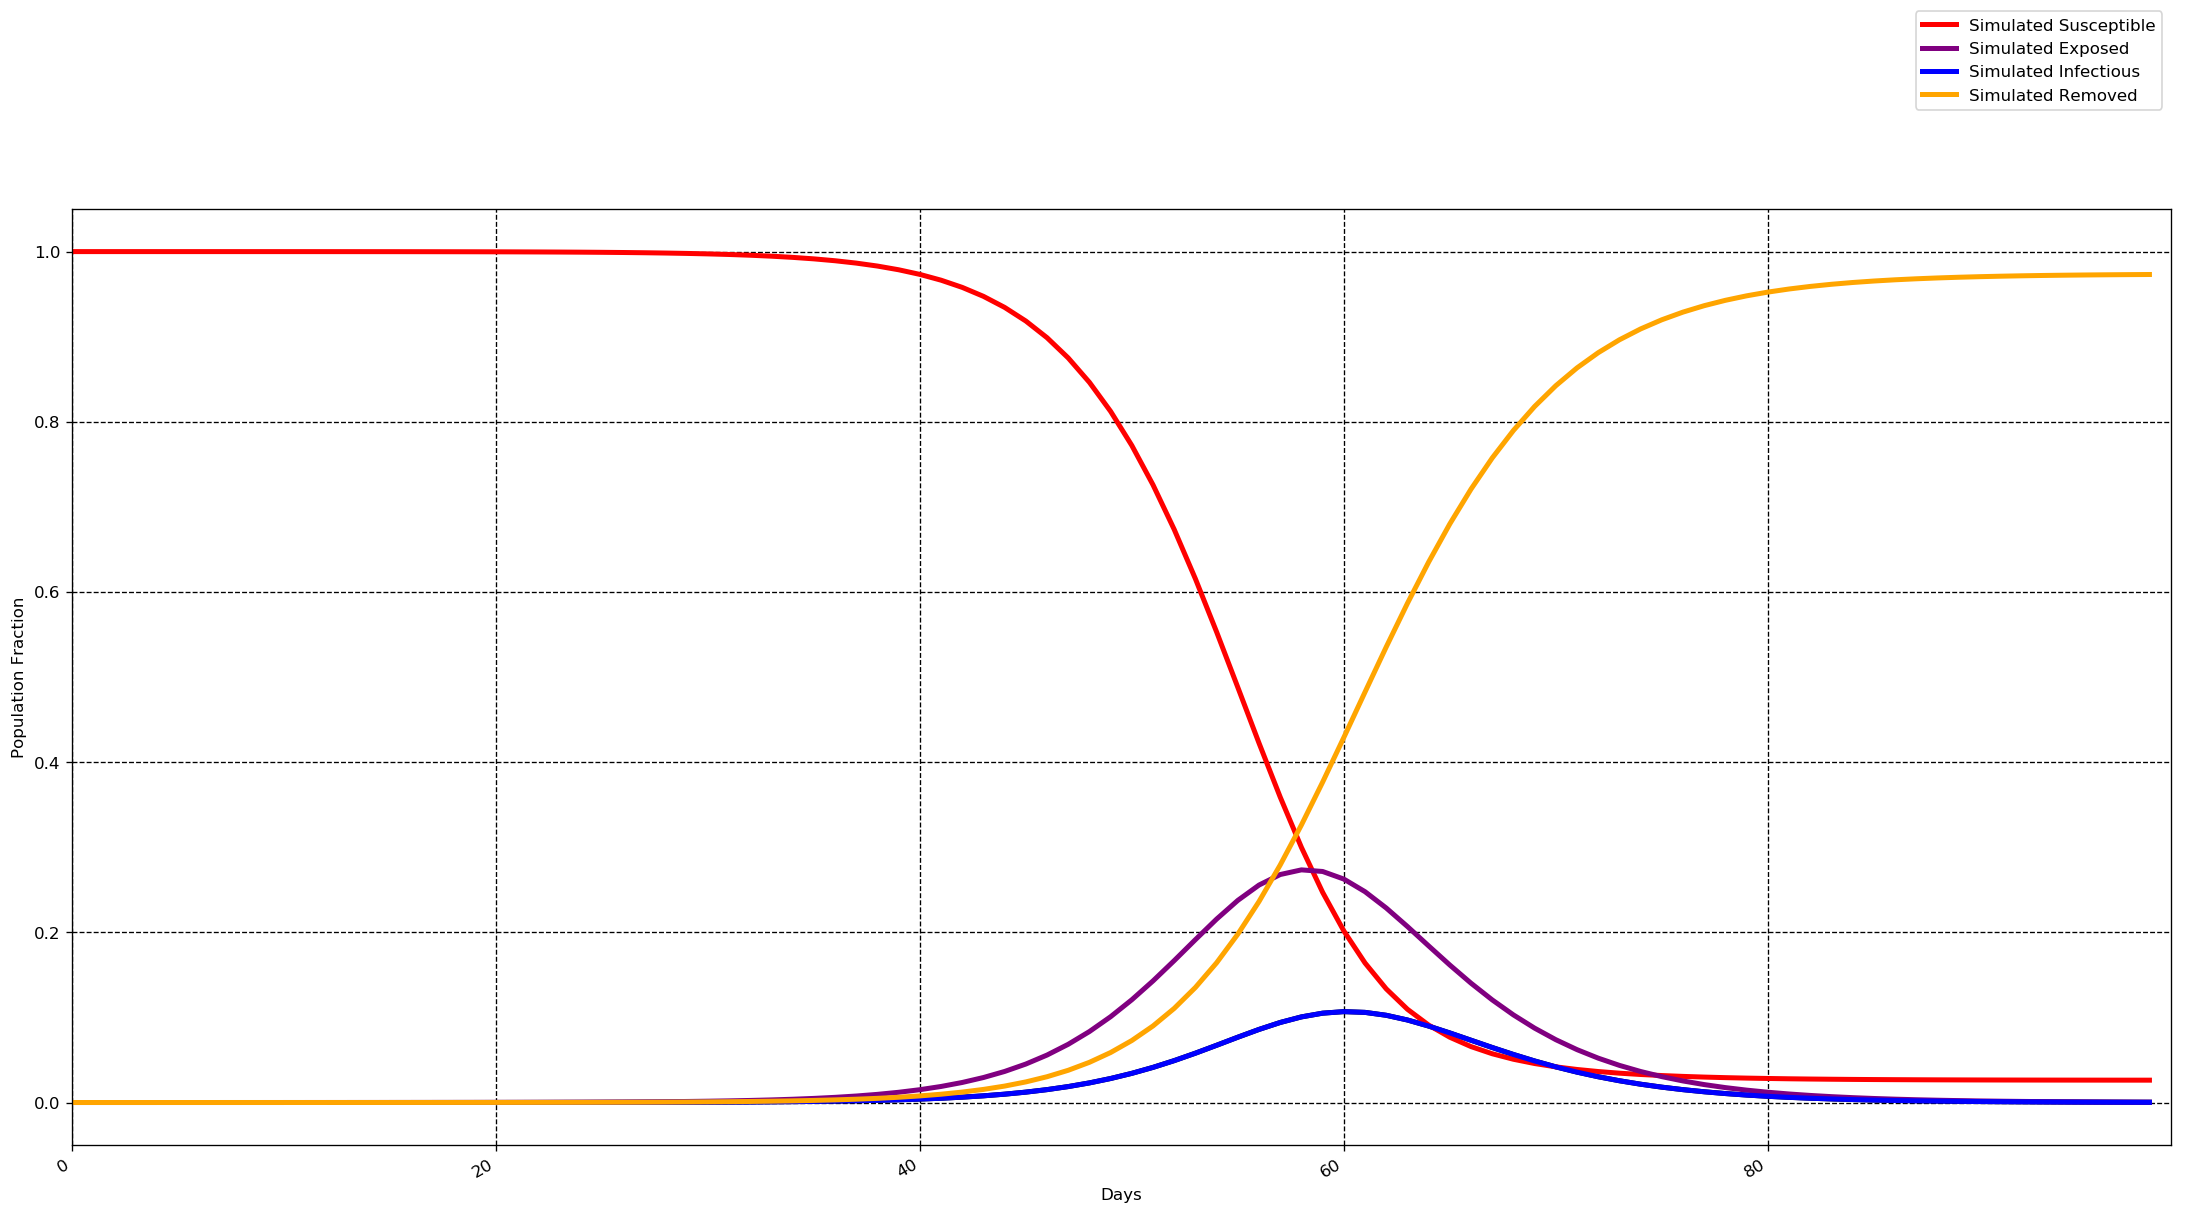

In [13]:
#print("Predicted maximum confirmed cases:%s" % str(int(max(results[:, 2]) * N)))
avg_susceptible = (min_results[:,0] + max_results[:,0])/2
avg_exposure = (min_results[:,1] + max_results[:,1])/2
avg_infectious = (min_results[:,2] + max_results[:,2])/2
avg_removed = (min_results[:,3] + max_results[:,3])/2
plot_modeled(avg_susceptible, avg_exposure, avg_infectious, avg_removed)

Finally, we plot the relative frequency of each SEIR compartment over time when using the optimized parameters.

## Conclusion

This notebook showcases a relatively simplistic use of data in the Chicagoland COVID-19 Commons to build an optimized SEIR model. As the COVID-19 pandemic is an on-going event, these data are regularly updated. Fortunately, this notebook can simply be re-run and will automatically use the most up-to-date datasets.